## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
# pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image

# import datacube
import glob
import xarray as xr
import pandas as pd
import numpy as np

import datacube
# from datacube.utils.geometry import assign_crs
import odc.geo.xr
from dea_tools.plotting import xr_animation
from dea_tools.dask import create_local_dask_cluster
from intertidal.utils import intertidal_hillshade

# Connect to datacube
# dc = datacube.Datacube(app="Intertidal_elevation")

config = {
    'db_hostname': 'dea-dev-eks-proxy-share.endpoint.proxy-cxhoeczwhtar.ap-southeast-2.rds.amazonaws.com',
    'db_database': 'odc',
    'db_username': 'sandbox_reader',
    'db_password': 'ZWGRrBLmRs9WqTIj'
}
dc = datacube.Datacube(config=config)

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36219,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:37179,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40989/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:36313,


In [3]:
load_params = dict(
    dask_chunks={"x": 1024, "y": 1024}
                  )
 
query_params = dict(y=( -7.98203, -46.48530),
                    x=(110.56136, 160.33740),
                    time=("2016", "2022"))
 
ds = dc.load(product="ga_s2ls_intertidal_cyear_3",
             **query_params,
             **load_params,
             resolution=(-10000,10000),
             )

In [4]:
test = ds.ta_hat.compute()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


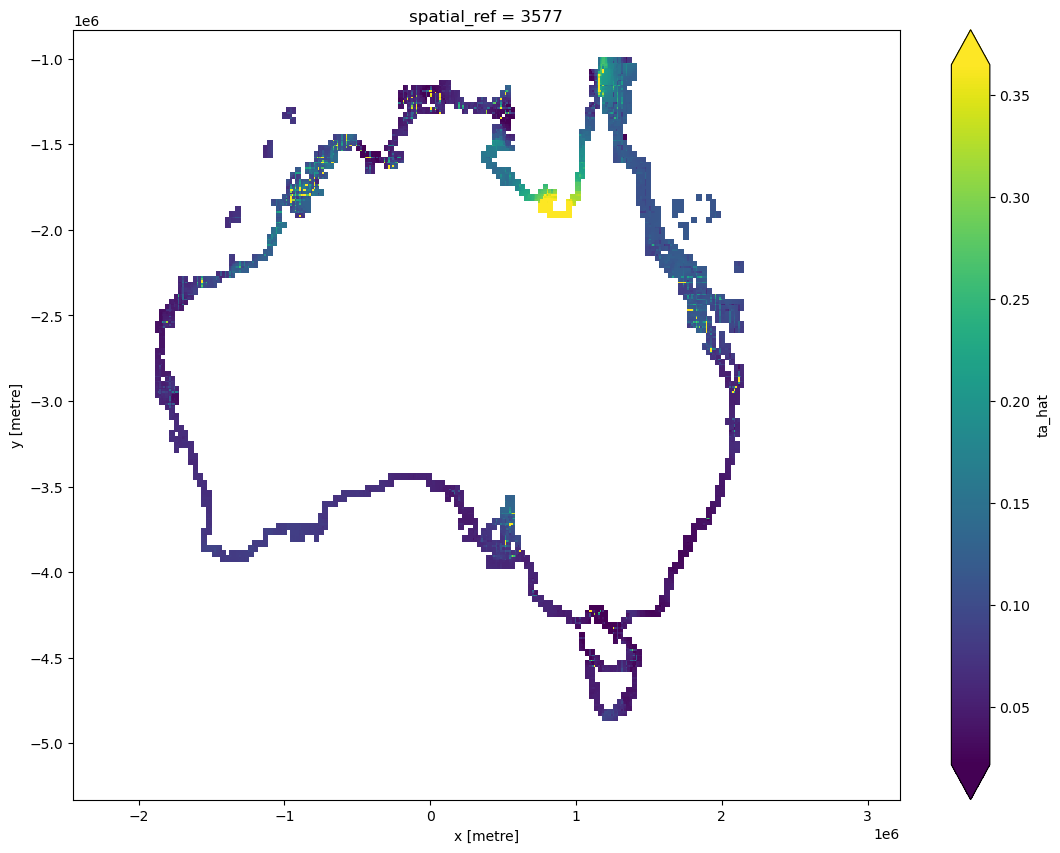

In [17]:
(test.max(dim="time") - test.min(dim="time")).plot.imshow(robust=True, interpolation="nearest", size=10)

In [ ]:
import logging
import yaml
import fsspec
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthBegin, MonthEnd, YearBegin, YearEnd
from pathlib import Path


def intertidal_hillshade(
    elevation,
    freq,
    azdeg=315,
    altdeg=45,
    dyx=10,
    vert_exag=100,
    **shade_kwargs,
):
    """
    Create a hillshade array for an intertidal zone given an elevation
    array and an extents array.

    Parameters
    ----------
    elevation : str or xr.DataArray
        An xr.DataArray or a path to the elevation raster file.
    azdeg : float, optional
        The azimuth angle of the light source, in degrees. Default is 315.
    altdeg : float, optional
        The altitude angle of the light source, in degrees. Default is 45.
    dyx : float, optional
        The distance between pixels in the x and y directions, in meters.
        Default is 10.
    vert_exag : float, optional
        The vertical exaggeration of the hillshade. Default is 100.
    **shade_kwargs : optional
        Additional keyword arguments to pass to
        `matplotlib.colors.LightSource.shade()`.

    Returns
    -------
    xr.DataArray
        The hillshade array for the intertidal zone.
    """

    from matplotlib.colors import LightSource, Normalize
    import matplotlib.pyplot as plt
    import xarray as xr

    # Fill upper and bottom of intertidal zone with min and max heights
    # so that hillshade can be applied across the entire raster
    elev_min, elev_max = elevation.quantile([0, 1])    
    elevation_filled = xr.where(elevation.isnull() & (freq < 50), elev_max, elevation).fillna(elev_min)

    from scipy.ndimage import gaussian_filter
    input_data = gaussian_filter(elevation_filled, sigma=1)

    # Create hillshade based on elevation data
    ls = LightSource(azdeg=azdeg, altdeg=altdeg)
    hillshade = ls.shade(
        input_data,
        cmap=plt.cm.viridis,
        blend_mode=lambda x, y: x * y,
        vert_exag=vert_exag,
        dx=dyx,
        dy=dyx,
        **shade_kwargs,
    )

    # Mask out non-intertidal pixels
    hillshade = np.where(
        np.expand_dims(elevation.notnull().values, axis=-1), hillshade, np.nan
    )

    # Create a new xarray data array from the numpy array
    hillshaded_da = xr.DataArray(
        hillshade * 255,
        dims=["y", "x", "variables"],
        coords={
            "y": elevation.y,
            "x": elevation.x,
            "variables": ["r", "g", "b", "a"],
        },
    )

    return hillshaded_da

In [ ]:
# Cape Capricorn
name = "capecapricorn"
s2_product = "ga_s2bm_ard_3"
s2_date = "2023-07-01"
t, l = -23.491, 151.142
b, r = -23.531, 151.241

# Burdekin
name = "burdekin"
s2_product = "ga_s2am_ard_3"
s2_date = "2023-07-09"
t, l = -19.615, 147.555
b, r = -19.659, 147.615

# Pilbara
name = "pilbara"
s2_product = "ga_s2bm_ard_3"
s2_date = "2023-07-23"
t, l = -20.76, 116.44
b, r = -20.825, 116.53

# Spoilbank
name = "spoilbank"
s2_product = "ga_s2am_ard_3"
s2_date = "2023-07-15"
t, l = -20.28, 118.575
b, r = -20.32, 118.66

query_params = dict(x=(l, r), y=(t, b))

load_params = dict(
    dask_chunks={},
)

ds = (
    dc.load(
        product="ga_s2ls_intertidal_cyear_3",
        measurements=["elevation", "qa_ndwi_freq"],
        **query_params,
        **load_params
    )
    .squeeze()
    .compute()
)

import odc.geo.xr

ds_rgb = (
    dc.load(
        product=s2_product,
        measurements=["red", "green", "blue"],
        time=s2_date,
        like=ds.odc.geobox.compat,
        group_by="solar_day",
        dask_chunks={},
    )
    .squeeze()
    .compute()
)

ds_rgb.to_array().plot.imshow(robust=True)
ds.isel(time=0).elevation.plot.imshow(ax=plt.gca(), cmap="viridis", robust=True)

In [ ]:
years = ("2016", "2017", "2018", "2019", "2020", "2021", "2022")

vmin, vmax = ds.elevation.quantile([0.03, 0.95]).values

out_list = []
for year in years:
    out_list.append(
        intertidal_hillshade(
            elevation=ds.elevation.squeeze(),
            freq=ds.qa_ndwi_freq.sel(time=year).squeeze(),
            altdeg=45,
            vert_exag=900,
            vmin=vmin,
            vmax=vmax,
            fraction=1,
        )
    )

intertidal_da = xr.concat(out_list, dim=ds.time)
intertidal_da = intertidal_da.odc.assign_crs("EPSG:3577")

ds_rgba = ds_rgb.odc.to_rgba(vmin=0, vmax=2000).rename(band="variables")
intertidal_ds = (
    intertidal_da.fillna(ds_rgba * 1.1)
    .clip(0, 255)
    .astype(np.uint8)
    .to_dataset("variables")
)
intertidal_ds = intertidal_ds.odc.assign_crs("EPSG:3577")

In [ ]:
fname = f"DEAIntertidal_timeseries_animation_{name}.mp4"
xr_animation(
    ds=intertidal_ds.interp(
        time=pd.date_range("2016-07-02", "2022-07-01", freq="3M", inclusive="both")
    ),
    bands=["r", "g", "b"],
    imshow_kwargs={"vmin": 0, "vmax": 255, "interpolation": "bilinear"},
    output_path=fname,
    interval=50,
    show_date="%Y",
    width_pixels=1200,
    annotation_kwargs={"fontsize": 40},
    # limit=3,
)
# Image(fname)

In [ ]:

# for n, (i, da) in enumerate(intertidal_ds.interp(time=pd.date_range("2016-07-02", "2022-07-01", freq="3M", inclusive="both")).groupby("time")):
#     print(i)
    
#     plt.imsave(f"intertidal_{n}.jpg", np.ascontiguousarray(da.to_array().astype(np.uint8).transpose("y", "x", "variable").values))